In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta
register_matplotlib_converters()

# Generate some data

### $y$<sub>t</sub> = 50 + 0.4ϵ<sub>t-1</sub> + 0.3ϵ<sub>t-2</sub> + ϵ<sub>t</sub>
### ϵ<sub>t</sub> ~ N(0,1)

In [2]:
errors = np.random.normal(0, 1, 400)

In [3]:
date_index = pd.date_range(start='9/1/2019', end='1/1/2020')

In [4]:
mu = 50
series = []
for t in range(1,len(date_index)+1):
    series.append(mu + 0.4*errors[t-1] + 0.3*errors[t-2] + errors[t])

In [5]:
series = pd.Series(series, date_index)
series = series.asfreq(pd.infer_freq(series.index))
series

2019-09-01    48.108832
2019-09-02    47.938731
2019-09-03    50.151814
2019-09-04    51.797663
2019-09-05    51.399276
                ...    
2019-12-28    47.081889
2019-12-29    49.964673
2019-12-30    49.386606
2019-12-31    48.572652
2020-01-01    50.618914
Freq: D, Length: 123, dtype: float64

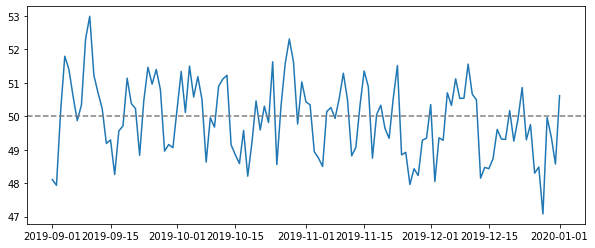

In [6]:
plt.figure(figsize=(10,4))
plt.plot(series)
plt.axhline(mu, linestyle='--', color='grey')

In [7]:
def calc_corr(series, lag):
    return pearsonr(series[:-lag], series[lag:])[0]

# ACF

<BarContainer object of 10 artists>

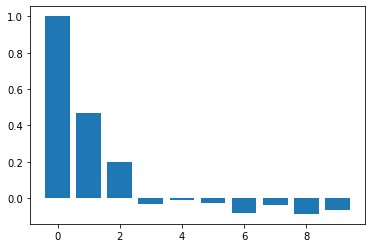

In [8]:
acf_vals = acf(series)
num_lags = 10
plt.bar(range(num_lags), acf_vals[:num_lags])

# PACF

<BarContainer object of 20 artists>

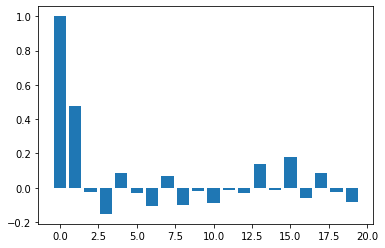

In [9]:
pacf_vals = pacf(series)
num_lags = 20
plt.bar(range(num_lags), pacf_vals[:num_lags])

# Get training and testing sets

In [10]:
train_end = datetime(2019,12,30)
test_end = datetime(2020,1,1)

train_data = series[:train_end]
test_data = series[train_end + timedelta(days=1):test_end]

# Fit MA model

In [11]:
# create the model
model = ARIMA(train_data, order=(0,0,1))

In [12]:
#fit the model
model_fit = model.fit()

In [13]:
#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  121
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -172.452
Date:                Tue, 01 Nov 2022   AIC                            350.904
Time:                        15:32:44   BIC                            359.291
Sample:                    09-01-2019   HQIC                           354.310
                         - 12-30-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.9353      0.129    385.942      0.000      49.682      50.189
ma.L1          0.3737      0.093      4.019      0.000       0.191       0.556
sigma2         1.0114      0.153      6.625      0.0

# Predicted model

In [14]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [15]:
#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)

In [16]:
residuals = test_data - predictions

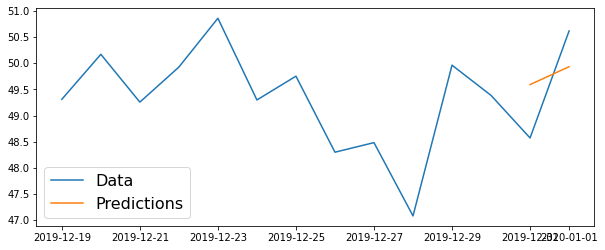

In [17]:
plt.figure(figsize=(10,4))

plt.plot(series[-14:])
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

In [18]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.0173


In [19]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 0.8685395790768223
